# Imports and helper functions

In [29]:
import os
# change directory in order to be able to import python scripts from the common package
if os.getcwd().endswith('coinrun'): os.chdir(os.path.expanduser(".."))

In [30]:
import torch
from common import psm
import matplotlib.pylab as plt
import numpy as np
from env import CoinRunReplayBuffer 


In [31]:

def compare2_imgs(a,b,title1, title2, scale=3, compare_idx=0):
   fig = plt.figure(figsize=(scale*2, scale))
   axarr = [fig.add_subplot(121), fig.add_subplot(122)]
   axarr[0].imshow(a.squeeze(), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(b.squeeze(), cmap='gray', vmin=0., vmax=1.)
   axarr[0].title.set_text(title1)
   axarr[1].title.set_text(title2)
   # plt.savefig(f"{compare_idx}.pdf", bbox_inches='tight', pad_inches=0)
   plt.show()
   

def compare_imgs(a,b,c,title1, title2, title3, scale=3, compare_idx=0):
   fig = plt.figure(figsize=(scale*3, scale))
   axarr = [fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)]
   axarr[0].imshow(a.squeeze(), cmap='gray', vmin=0., vmax=1.)
   axarr[1].imshow(b.squeeze(), cmap='gray', vmin=0., vmax=1.)
   axarr[2].imshow(c.squeeze(), cmap='gray', vmin=0., vmax=1.)
   axarr[0].title.set_text(title1)
   axarr[1].title.set_text(title2)
   axarr[2].title.set_text(title3)
   # plt.savefig(f"{compare_idx}.pdf", bbox_inches='tight', pad_inches=0)
   plt.show()
   

In [32]:
buffer = CoinRunReplayBuffer("cpu", 2, './coinrun/dataset/seeds-0-9')
states_x, actions_x = buffer.sample_trajectory()
states_y, actions_y = buffer.sample_trajectory()
print(f"State shapes: x: {states_x.shape}, y: {states_y.shape}")

State shapes: x: torch.Size([95, 3, 64, 64]), y: torch.Size([33, 3, 64, 64])


In [33]:
# states_x, actions_x = states_x[-200:], actions_x[-200:] 
# states_y, actions_y = states_y[-200:], actions_y[-200:] 

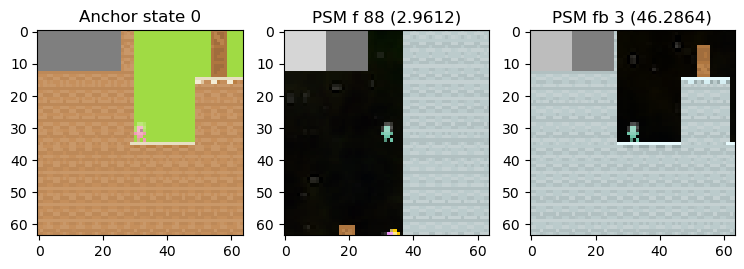

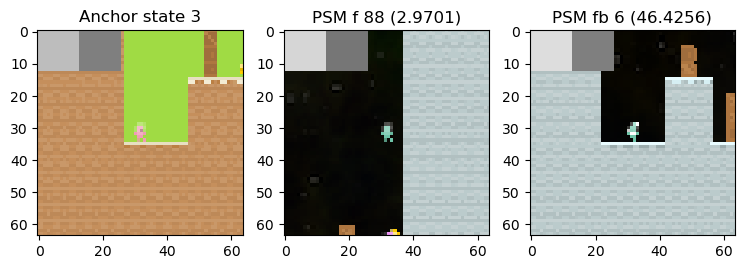

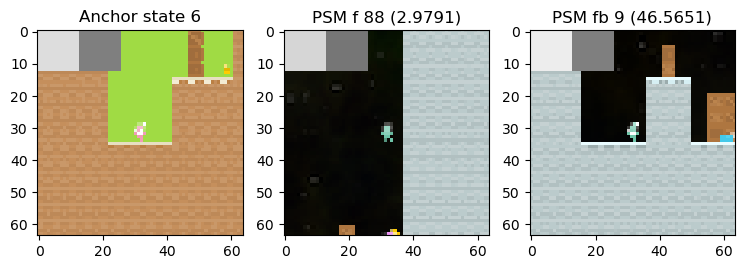

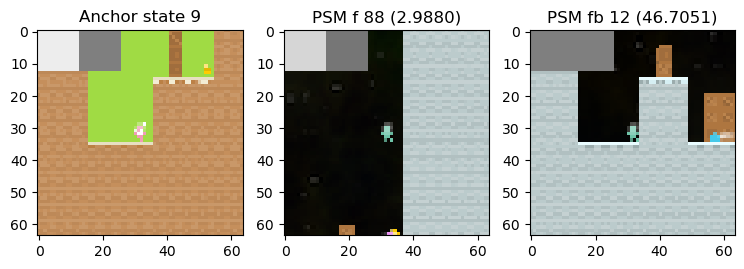

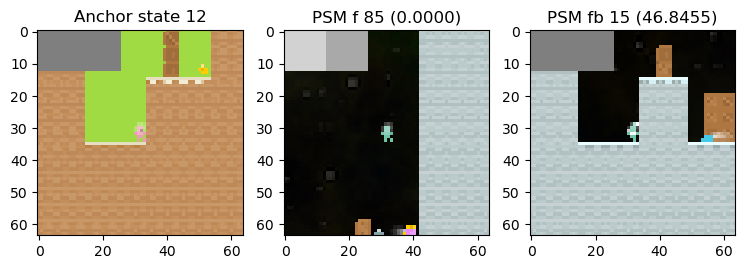

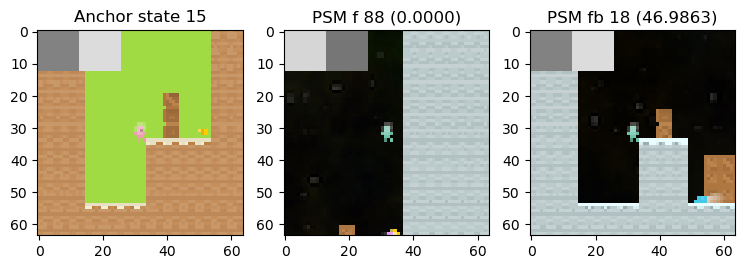

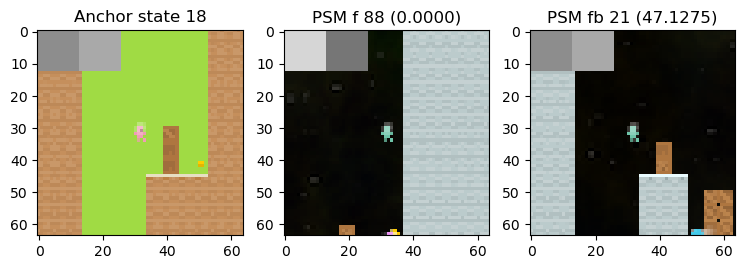

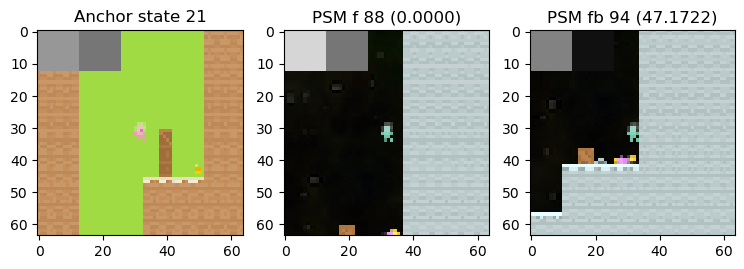

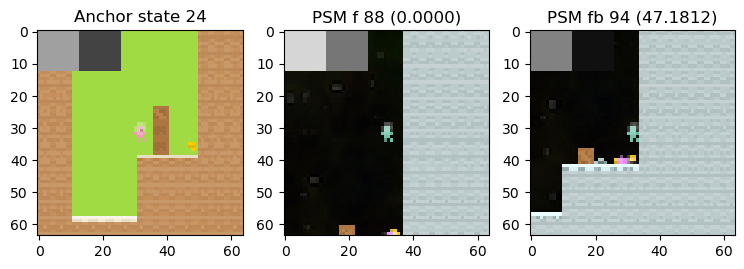

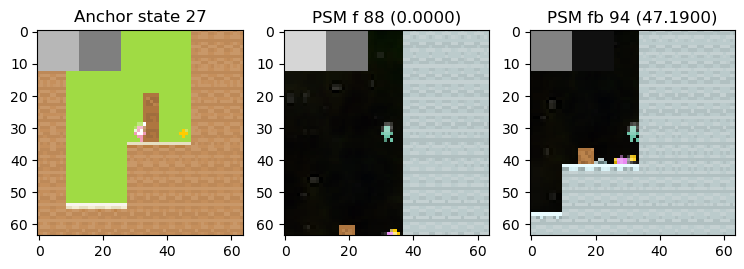

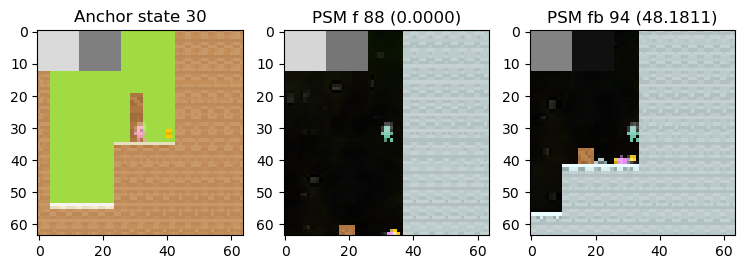

In [34]:
#psm_forward = psm.psm_default(actions_x, actions_y, gamma=0.90)
#psm_fb = psm.psm_fb(actions_x, actions_y, gamma=0.90)

psm_forward_fast = psm.psm_f_fast(actions_x, actions_y, gamma=0.999)
psm_fb_fast = psm.psm_fb_fast(actions_x, actions_y, gamma=0.999)

#assert np.allclose(psm_forward, psm_forward_fast) , "Different psm values for fast and slow version!"
#assert np.allclose(psm_fb, psm_fb_fast) , "Different psm values for fast and slow version!"

beta = 0.01
# psm_forward = np.exp(-psm_forward_fast / beta)
# psm_fb = np.exp(-psm_fb_fast / beta)

for compare_idx in range(0, len(actions_y)):                            
    # Given the state at index compare_idx, which state in Y is most similar?
    idx_forward = np.argmin(psm_forward_fast[:, compare_idx])
    idx_fb = np.argmin(psm_fb_fast[:,compare_idx])

    if compare_idx % 3 == 0:
        compare_imgs(
            np.moveaxis(states_y[compare_idx].numpy(), 0, -1), 
            np.moveaxis(states_x[idx_forward].numpy(), 0, -1), 
            np.moveaxis(states_x[idx_fb].numpy(), 0, -1), 
            f"Anchor state {compare_idx}",
            f"PSM f {idx_forward} ({psm_forward_fast[idx_forward][compare_idx]:.4f})",
            f"PSM fb {idx_fb} ({psm_fb_fast[idx_fb][compare_idx]:.4f})")


PSM F: mean: 0.17322467267513275 var: 0.07537622004747391
PSM FB: mean: 0.06670532375574112 var: 0.0257710013538599


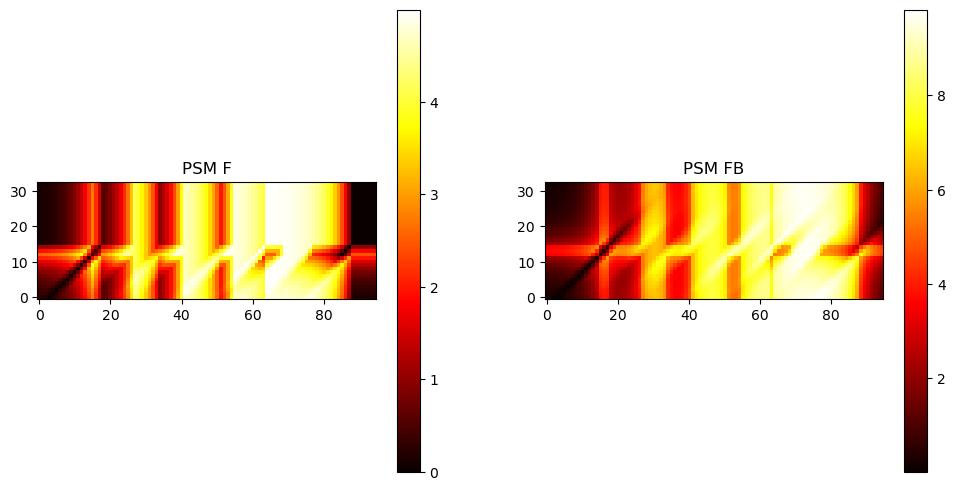

In [35]:
psm_f = psm.psm_f_fast(actions_x, actions_y, gamma=.8)
psm_fb = psm.psm_fb_fast(actions_x, actions_y, gamma=.8)
#print(actions_x)
# calculate measure

beta = .9
psm_f_measure = torch.exp(-psm_f/beta)
psm_fb_measure = torch.exp(-psm_fb/beta)

print(f"PSM F: mean: {psm_f_measure.mean()} var: {psm_f_measure.var()}")
print(f"PSM FB: mean: {psm_fb_measure.mean()} var: {psm_fb_measure.var()}")


fig = plt.figure(figsize=(12,6))
plot1 = fig.add_subplot(1, 2, 1)
im = plot1.imshow(psm_f.T, origin='lower', cmap='hot', interpolation='nearest')
plot1.set_title("PSM F")
fig.colorbar(im, ax=plot1)


plot2 = fig.add_subplot(1, 2, 2)
plot2.set_title("PSM FB")
im = plot2.imshow(psm_fb.T, origin='lower', cmap='hot', interpolation='nearest')
fig.colorbar(im, ax=plot2)
plt.show()